# PCA for Score Scale

Date: 06/28/2019

## Unit and Data Import

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Import data set
cleaned_filepath = 'YSET_Dec2008_Dec2019_cleaned20190531.csv'
key_filepath = 'YSET Database_ALL YSETs_2008-Feb 2019.csv'

key = pd.read_csv(key_filepath)
#key = key.set_index('key')

df = pd.read_csv(cleaned_filepath)
df.head()

,Unnamed: 0,UniqueID,YSET_I_R,y_TotalFactors,y_DateS1_Interview,YouthStatus,Agency,GRYD_Zone,Ethnicity_Asian,Ethnicity_Black,...,YSET_Days,YSET_Version,YSETDirections,YSETDirections_ETO,YSETResults,YSETStatus,GRYD_Zone2018,GRYD_ZoneSubRegion,PrimaryLast,PrimaryLast1
0,3131,1010.0,11.0,,2010-05-13,,9,5,0.0,0,...,,,,,2.0,,,,,1
1,6394,1010.0,12.0,1,2011-07-28,,9,5,0.0,0,...,,,,,1.0,,,,,1
2,6021,1042.0,11.0,7,2011-09-27,,17,7,0.0,0,...,,,,,2.0,,,,,1
3,3296,1043.0,11.0,8,2010-05-17,,9,5,0.0,0,...,,,,,2.0,,,,,1
4,6500,1043.0,12.0,,2011-07-27,,9,5,0.0,0,...,,,,,2.0,1,,,,1


In [3]:
df.shape

(32896, 394)

## Basic Exploration of Data

### Risk Factor

In [8]:
df['y_TotalFactors'] = pd.to_numeric(df['y_TotalFactors'], downcast = 'integer', errors = 'coerce')
df.loc[(df['y_TotalFactors'] == 88), 'y_TotalFactors'] = np.nan
df['y_TotalFactors'].describe(percentiles = [.25, .5, .75])

count    31902.000000
mean         3.379945
std          2.732965
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max          9.000000
Name: y_TotalFactors, dtype: float64

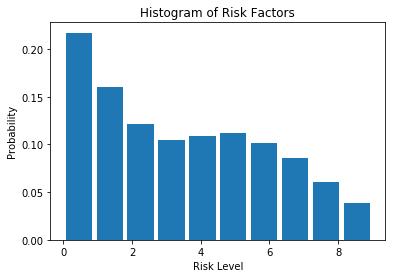

In [9]:
plt.hist(df['y_TotalFactors'],density = True, rwidth=0.85)
plt.xlabel('Risk Level')
plt.ylabel('Probability')
plt.title('Histogram of Risk Factors')
plt.show()

### Unique ID

In [4]:
df['UniqueID'] = pd.to_numeric(df['UniqueID'], downcast = 'integer', errors = 'coerce')

In [5]:
# Number of unique individuals who have ever submitted a response 

df.UniqueID.value_counts().describe()

count    22567.000000
mean         1.457704
std          0.717323
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: UniqueID, dtype: float64

In [6]:
# IDs with different numbers of snapshots

ID_6 = df.UniqueID.value_counts()[df.UniqueID.value_counts() == 6].index
ID_5 = df.UniqueID.value_counts()[df.UniqueID.value_counts() == 5].index
ID_4 = df.UniqueID.value_counts()[df.UniqueID.value_counts() == 4].index
ID_3 = df.UniqueID.value_counts()[df.UniqueID.value_counts() == 3].index
ID_2 = df.UniqueID.value_counts()[df.UniqueID.value_counts() == 2].index
ID_1 = df.UniqueID.value_counts()[df.UniqueID.value_counts() == 1].index

## Cleaning up outlier entries in data

### Section IJ

In [7]:
df['Score_ScaleIJ_new'] = 0

for col in df.loc[:,'ij40_6mos_combo':'ij56_ever_combo'].columns.tolist():
    
    df[col] = pd.to_numeric(df[col], downcast = 'integer', errors = 'coerce')
    df = df[df[col] != -1]
    df = df[df[col] != 11]# drop

    df.loc[(df[col] == 99), col] = np.nan
    df.loc[(df[col] == 9), col] = np.nan
    
    df['Score_ScaleIJ_new'] += df[col]
    
    #print(df[col].value_counts())

### Section Norms (Groups of Friends)

In [62]:
df['EG85a']=pd.to_numeric(df['EG85a'], downcast = 'integer', errors = 'coerce')
df['EG80']=pd.to_numeric(df['EG80'], downcast = 'integer', errors = 'coerce')
df['EG81']=pd.to_numeric(df['EG81'], downcast = 'integer', errors = 'coerce')
df['EG84']=pd.to_numeric(df['EG84'], downcast = 'integer', errors = 'coerce')

In [63]:
# Removing rows w invalid inputs 

# EG80
df = df[df.EG80 != -1]
df = df[df.EG80 != 3]
df = df[df.EG80 != 2]
df = df[df.EG80 != 11]
df = df[df.EG80 != 33]# drop

df.loc[(df['EG80'] == 99), 'EG80'] = np.nan
df.loc[(df['EG80'] == 999), 'EG80'] = np.nan
df.loc[(df['EG80'] == 9), 'EG80'] = np.nan


# EG81
df = df[df.EG81 != 11]# drop

df.loc[(df['EG81'] == 99), 'EG81'] = np.nan
df.loc[(df['EG81'] == 999), 'EG81'] = np.nan
df.loc[(df['EG81'] == 9), 'EG81'] = np.nan

# EG84
df.loc[(df['EG84'] == 99), 'EG84'] = np.nan
df.loc[(df['EG84'] == 999), 'EG84'] = np.nan
df.loc[(df['EG84'] == 9), 'EG84'] = np.nan

# EG85a
df.loc[(df['EG85a'] == 99), 'EG85a'] = np.nan
df.loc[(df['EG85a'] == 9), 'EG85a'] = np.nan


In [64]:
# Add up the scores

df['Score_ScaleNorms'] = df['EG80'] + df['EG81']+ df['EG84'] + df['EG85a']

In [65]:
df['Score_ScaleNorms'].value_counts()

0.0    18267
1.0     3563
2.0     3240
3.0     1394
4.0      402
Name: Score_ScaleNorms, dtype: int64

## Creating Dataframes for Analysis

In [11]:
# Extracting score scales from cleaned data
df_byfac =df.loc[:,'Score_ScaleA':'Score_ScaleNorms']
df_byfac.drop(['Score_ScaleIJMissing','Score_ScaleIJWithGangMissing'],axis = 1,inplace=True)
for col in df_byfac:
     df_byfac[col] = pd.to_numeric(df_byfac[col], downcast = 'integer', errors = 'coerce')
        
df['y_DateS1_Interview'] = pd.to_datetime(df['y_DateS1_Interview'], errors='coerce')        
df_byfac['Date'] = df['y_DateS1_Interview']

df_byfac['Age'] = df['Age']
df_byfac['Score_ScaleIJ_new'] = df['Score_ScaleIJ_new']
df_byfac['UniqueID'] = df['UniqueID']

# Moving Unique ID to the front
cols = df_byfac.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_byfac = df_byfac[cols]


In [ ]:

for i in range(n2.shape[0]):
    if n2[i,37]>6:
        n2[i,37] = 6
    if n2[i,38]>6:
        n2[i,38] = 6
n2[n2<0]=float('NaN')
n2[n2==9]=float('NaN')
n2 = n2[~np.isnan(n2).any(axis=1)]


In [61]:
df_byfac.head()

,UniqueID,Score_ScaleA,Score_ScaleB,Score_ScaleC,Score_ScaleDE,Score_ScaleF,Score_ScaleFS,Score_ScaleG,Score_ScaleH,Score_ScaleIJ,Score_ScaleK,Score_ScaleP,Score_ScaleT,Score_ScaleNorms,Date,Age,Score_ScaleIJ_new
0,1010,12.0,11.0,4.0,15.0,17.0,NaN,8.0,15.0,2,NaN,NaN,NaN,NaN,2010-05-13,16,5.0
1,1010,13.0,7.0,0.0,11.0,17.0,NaN,5.0,6.0,5,13.0,NaN,0.0,36.0,2011-07-28,18,9.0
2,1042,12.0,10.0,4.0,13.0,21.0,NaN,17.0,26.0,6,NaN,NaN,2.0,NaN,2011-09-27,18,12.0
3,1043,19.0,15.0,1.0,14.0,24.0,NaN,18.0,24.0,10,NaN,NaN,2.0,NaN,2010-05-17,15,17.0
4,1043,13.0,9.0,1.0,13.0,19.0,NaN,13.0,15.0,10,13.0,NaN,NaN,2.0,2011-07-27,16,12.0


## Clearning data for PCA

In [66]:
# create new dataframe by dropping 
df_pca = df_byfac.copy()
df_pca.drop('Score_ScaleIJ',axis = 1,inplace = True)
df_pca.dropna(inplace = True)

In [45]:
x_array = np.array(df_pca['Score_ScaleA'])
x_array = preprocessing.normalize([df_pca['Score_ScaleA'], df_pca['Score_ScaleB'], df_pca['Score_ScaleB']])
print(x_array)

[[0.00696132 0.00324862 0.00464088 ... 0.00881767 0.00603314 0.00742541]
 [0.00399627 0.0029972  0.00399627 ... 0.00399627 0.0029972  0.0059944 ]]


In [47]:
df_pca['Score_ScaleA'].value_counts()

10.0    1739
12.0    1702
13.0    1652
11.0    1608
14.0    1606
15.0    1477
16.0    1404
9.0     1403
17.0    1320
18.0    1197
8.0     1056
19.0     985
20.0     845
7.0      706
21.0     652
6.0      481
22.0     447
23.0     309
24.0     238
25.0     138
26.0      98
27.0      50
28.0      32
29.0      23
30.0      11
Name: Score_ScaleA, dtype: int64

In [67]:
dfr2 = df_pca.loc[:, 'Score_ScaleA':'Score_ScaleNorms']
d2 = dfr2.convert_objects(convert_numeric=True)
n2 = d2.to_numpy()

In [68]:
pca = PCA(n_components=12)
converted_n2 = pca.fit_transform(n2)
PrincipleComponents = pca.components_
principle3 = PrincipleComponents[0:3]

In [69]:
print(pca.explained_variance_ratio_)

[0.48893668 0.15964998 0.11180305 0.04970342 0.03785606 0.03560928
 0.03304602 0.02800369 0.01881117 0.01759686 0.01134583 0.00673801]


### WE FIGURED OUT WHEN THEY STARTED TO ASK FS QUESTIONS!!!
- We will split the data into two: one before the key date (2013-11-1, when they changed the questionnaire) and one after.

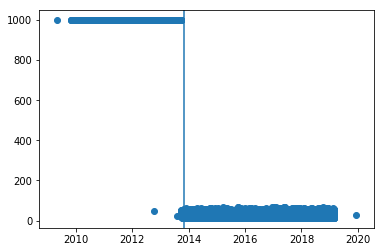

In [20]:
import time
from datetime import date

keydate = date(2013, 11, 1)

df_byfac.Score_ScaleFS[df_byfac['Score_ScaleFS'].isna()] = 999

plt.scatter(x=df_byfac.Date,y=df_byfac.Score_ScaleFS)
plt.axvline(x=keydate)
plt.show()

df_byfac.loc[(df_byfac['Score_ScaleFS'] == 999), 'Score_ScaleFS'] = np.nan


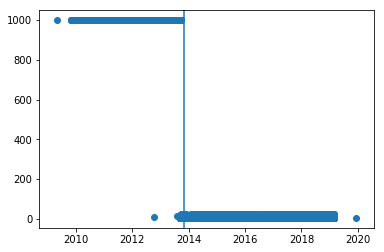

In [21]:
df_byfac.Score_ScaleP[df_byfac['Score_ScaleP'].isna()] = 999

plt.scatter(x=df_byfac.Date,y=df_byfac.Score_ScaleP)
plt.axvline(x=keydate)
plt.show()

df_byfac.loc[(df_byfac['Score_ScaleP'] == 999), 'Score_ScaleP'] = np.nan

### Split data up into "Before Keydate" and "After Keydate"

In [22]:
# Before keydate

df_bkey = df_byfac[df_byfac.Date < keydate]

# Drop questions that wasn't asked before keydate
df_bkey.drop(['Score_ScaleFS','Score_ScaleP'],axis = 1,inplace=True)

In [23]:
# After keydate 
df_akey = df_byfac[df_byfac.Date >= keydate]

## Linear Regression with Scales

### Before keydate

Things left to do:

- Model validity checking / Transformation
- **Plotting**
- Predictor selecting: mix and match?
- Explain meaning of the slopes

In [24]:
import statsmodels.api as sm

In [96]:
# list of colnames we are using as X
cnames = df_bkey.loc[:,'Score_ScaleA':'Score_ScaleH'].columns.tolist()
cnames.extend(df_bkey.loc[:,'Score_ScaleK':'Score_ScaleNorms'].columns.tolist())

df_bkey.dropna(inplace = True)

X_bkey = sm.add_constant(df_bkey[cnames])
Y_bkey= df_bkey["Score_ScaleIJ_new"]

In [31]:
X_bkey.head()

,Score_ScaleA,Score_ScaleB,Score_ScaleC,Score_ScaleDE,Score_ScaleF,Score_ScaleG,Score_ScaleH,Score_ScaleK,Score_ScaleT,Score_ScaleNorms
6,11.0,7.0,2.0,10.0,15.0,18.0,14.0,14.0,1.0,0.0
10,15.0,4.0,2.0,15.0,15.0,15.0,20.0,17.0,1.0,0.0
14,16.0,5.0,5.0,13.0,18.0,15.0,11.0,20.0,0.0,3.0
22,11.0,10.0,2.0,11.0,20.0,12.0,15.0,16.0,0.0,0.0
34,9.0,5.0,4.0,10.0,12.0,7.0,9.0,13.0,1.0,1.0


In [97]:
# Note the difference in argument order
model_bkey = sm.OLS(Y_bkey, X_bkey).fit()
predictions_bkey = model_bkey.predict(X_bkey) # make the predictions by the model

# Print out the statistics
model_bkey.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     615.8
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:59:51   Log-Likelihood:                -14070.
No. Observations:                5225   AIC:                         2.816e+04
Df Residuals:                    5214   BIC:                         2.823e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.5634      0.229    -24.305      0.000      -6.012      -5.115
Score_ScaleA        -0.0031      0.017     -0.181      0.856      -0.036       0.030
Score_ScaleB         0.1228      0.019      6.421      0.000       0.085       0.160
Score_ScaleC         0.2905      0.033      8.773      0.000       0.226       0.355
Score_ScaleDE        0.0685      0.020      3.383      0.001       0.029       0.108
Score_ScaleF         0.2005      0.016     12.326      0.000       0.169       0.232
Score_ScaleG         0.0338      0.013      2.663      0.008       0.009       0.059
Score_ScaleH         0.3155      0.015     21.463      0.000       0.287       0.344
Score_ScaleK         0.0283      0.010      2.702      0.007       0.008       0.049
Score_ScaleT         0.4981      0.089      5.570      0.000       0.323       0.673
Score_ScaleNorms     1.3307      0.058     22.762      0.000       1.216       1.445
==============================================================================
Omnibus:                      446.686   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              839.523
Skew:                           0.590   Prob(JB):                    5.01e-183
Kurtosis:                       4.570   Cond. No.                         170.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### After keydate

#### Modeling

In [ ]:
import statsmodels.api as sm

In [101]:
cnames_all = df_akey.loc[:,'Score_ScaleA':'Score_ScaleH'].columns.tolist()
cnames_all.extend(df_bkey.loc[:,'Score_ScaleK':'Score_ScaleNorms'].columns.tolist())
df_akey.dropna(inplace = True)

X_akey = sm.add_constant(df_akey[cnames_all])
Y_akey = df_akey["Score_ScaleIJ_new"]

In [102]:
X_akey.describe()

,const,Score_ScaleA,Score_ScaleB,Score_ScaleC,Score_ScaleDE,Score_ScaleF,Score_ScaleFS,Score_ScaleG,Score_ScaleH,Score_ScaleK,Score_ScaleT,Score_ScaleNorms
count,20317.0,20317.000000,20317.000000,20317.000000,20317.000000,20317.000000,20317.000000,20317.000000,20317.000000,20317.000000,20317.000000,20317.000000
mean,1.0,14.124871,6.101491,2.975489,12.121278,16.826795,31.302013,11.521829,9.604863,15.353349,0.324753,0.497022
std,0.0,4.591301,3.226859,1.780202,4.198822,5.156029,9.820572,4.664769,3.783701,5.131286,0.588048,0.911389
min,1.0,6.000000,3.000000,0.000000,4.000000,6.000000,13.000000,5.000000,5.000000,6.000000,0.000000,0.000000
25%,1.0,10.000000,3.000000,2.000000,9.000000,13.000000,24.000000,8.000000,7.000000,12.000000,0.000000,0.000000
50%,1.0,14.000000,5.000000,3.000000,13.000000,17.000000,31.000000,11.000000,8.000000,15.000000,0.000000,0.000000
75%,1.0,17.000000,9.000000,4.000000,16.000000,20.000000,38.000000,15.000000,11.000000,19.000000,1.000000,1.000000
max,1.0,30.000000,15.000000,7.000000,20.000000,30.000000,65.000000,25.000000,30.000000,111.000000,2.000000,4.000000


In [103]:
# Note the difference in argument order
model_akey = sm.OLS(Y_akey, X_akey).fit()
predictions_akey = model_akey.predict(X_akey) # make the predictions by the model

# Print out the statistics
model_akey.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     2378.
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        12:04:10   Log-Likelihood:                -53429.
No. Observations:               20317   AIC:                         1.069e+05
Df Residuals:                   20305   BIC:                         1.070e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.4958      0.108    -50.715      0.000      -5.708      -5.283
Score_ScaleA         0.0146      0.008      1.832      0.067      -0.001       0.030
Score_ScaleB         0.1011      0.010     10.436      0.000       0.082       0.120
Score_ScaleC         0.4001      0.016     24.890      0.000       0.369       0.432
Score_ScaleDE        0.0266      0.009      2.887      0.004       0.009       0.045
Score_ScaleF         0.1729      0.007     23.673      0.000       0.159       0.187
Score_ScaleFS        0.0098      0.003      3.404      0.001       0.004       0.015
Score_ScaleG        -0.0088      0.007     -1.288      0.198      -0.022       0.005
Score_ScaleH         0.3638      0.009     41.694      0.000       0.347       0.381
Score_ScaleK         0.0149      0.007      2.210      0.027       0.002       0.028
Score_ScaleT         0.7245      0.045     16.188      0.000       0.637       0.812
Score_ScaleNorms     1.3544      0.033     40.669      0.000       1.289       1.420
==============================================================================
Omnibus:                     2562.175   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7212.332
Skew:                           0.690   Prob(JB):                         0.00
Kurtosis:                       5.572   Cond. No.                         220.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Note: These two models before_keydate and after_keydate are almost consistent because the predictor Score_ScaleA is both statistically insignificant in both models. Also, according to Jerry's PCA model, Question t38 and t39 show dominant effects. In both of our models, predictor Score_ScaleT has rather bigger coefficients, which means they are contributing more to the models. However, in after_keydate 

#### Plotting

In [125]:
import seaborn as sns
from scipy import stats

In [87]:
#X_akey.shape
Y_akey.shape

(20317,)

#### Residual plot 

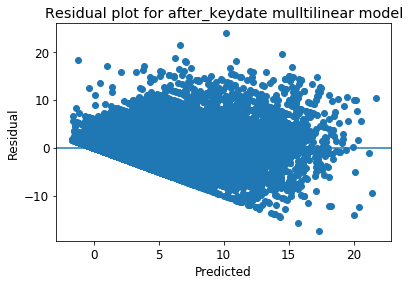

In [254]:
#create residual plot for after_keydate mulltilinear models 

difference = Y_akey - predictions_akey
plt.scatter(predictions_akey,difference)
plt.axhline(y=0)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual plot for after_keydate mulltilinear model')
plt.show()

#### Linear regression plot between the sum of other scores and score IJ

In [111]:
#create x as the sum of other scores
df_akey['Score_Sum'] = 0

for col in cnames_all:
    df_akey['Score_Sum'] += df_akey[col]

In [118]:
#build linear regression models

X_akeysum = df_akey['Score_Sum']
Y_akeysum= df_akey["Score_ScaleIJ_new"]

In [119]:
X_akeysum.head(10)

4514     85.0
4620     65.0
4627     90.0
4632    109.0
4635     73.0
4636    165.0
4638    153.0
4640    106.0
4641    138.0
4642    179.0
Name: Score_Sum, dtype: float64

In [120]:
Y_akeysum.shape

(20317,)

In [121]:
# Note the difference in argument order
model_akeysum = sm.OLS(Y_akeysum, X_akeysum).fit()
predictions_akeysum = model_akeysum.predict(X_akeysum) # make the predictions by the model

# Print out the statistics
model_akeysum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                 2.822e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        12:08:24   Log-Likelihood:                -59050.
No. Observations:               20317   AIC:                         1.181e+05
Df Residuals:                   20316   BIC:                         1.181e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Score_Sum      0.0418      0.000    167.990      0.000       0.041       0.042
==============================================================================
Omnibus:                     5852.362   Durbin-Watson:                   1.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15960.197
Skew:                           1.545   Prob(JB):                         0.00
Kurtosis:                       6.050   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

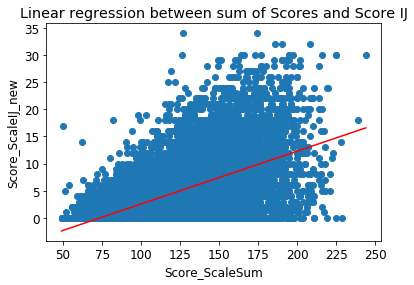

In [253]:
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeysum,Y_akeysum)
mn=np.min(X_akeysum)
mx=np.max(X_akeysum)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.scatter(X_akeysum,Y_akeysum)
plt.plot(x1,y1,'-r')
plt.xlabel('Score_ScaleSum')
plt.ylabel('Score_ScaleIJ_new')
plt.title('Linear regression between sum of Scores and Score IJ')
plt.show()

#### Several Linear regression plot between other Scores and Score IJ

In [163]:
#build linear regression models for Score B

X_akeyB = df_akey['Score_ScaleB']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyB = sm.OLS(Y_akey, X_akeyB).fit()
predictions_akeyB = model_akeyB.predict(X_akeyB) # make the predictions by the model

model_akeyB.summary()

In [164]:
#build linear regression models for Score C

X_akeyC = df_akey['Score_ScaleC']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyC = sm.OLS(Y_akey, X_akeyC).fit()
predictions_akeyC = model_akeyC.predict(X_akeyC) # make the predictions by the model

model_akeyC.summary()

In [175]:
#build linear regression models for Score DE

X_akeyDE = df_akey['Score_ScaleDE']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyDE = sm.OLS(Y_akey, X_akeyDE).fit()
predictions_akeyDE = model_akeyDE.predict(X_akeyDE) # make the predictions by the model

model_akeyDE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                 2.671e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:16:15   Log-Likelihood:                -59371.
No. Observations:               20317   AIC:                         1.187e+05
Df Residuals:                   20316   BIC:                         1.188e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Score_ScaleDE     0.4019      0.002    163.423      0.000       0.397       0.407
==============================================================================
Omnibus:                     5816.112   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16425.465
Skew:                           1.517   Prob(JB):                         0.00
Kurtosis:                       6.193   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [176]:
#build linear regression models for Score F

X_akeyF = df_akey['Score_ScaleF']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyF = sm.OLS(Y_akey, X_akeyF).fit()
predictions_akeyF = model_akeyB.predict(X_akeyF) # make the predictions by the model

model_akeyF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                 2.741e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:16:39   Log-Likelihood:                -59220.
No. Observations:               20317   AIC:                         1.184e+05
Df Residuals:                   20316   BIC:                         1.185e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleF     0.2946      0.002    165.566      0.000       0.291       0.298
==============================================================================
Omnibus:                     5851.141   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16366.181
Skew:                           1.532   Prob(JB):                         0.00
Kurtosis:                       6.154   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [177]:
#build linear regression models for Score FS

X_akeyFS = df_akey['Score_ScaleFS']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyFS = sm.OLS(Y_akey, X_akeyFS).fit()
predictions_akeyFS = model_akeyFS.predict(X_akeyFS) # make the predictions by the model

model_akeyFS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 1.967e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:17:02   Log-Likelihood:                -61017.
No. Observations:               20317   AIC:                         1.220e+05
Df Residuals:                   20316   BIC:                         1.220e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Score_ScaleFS     0.1463      0.001    140.264      0.000       0.144       0.148
==============================================================================
Omnibus:                     5145.855   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12321.408
Skew:                           1.414   Prob(JB):                         0.00
Kurtosis:                       5.561   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
#build linear regression models for Score H

X_akeyH = df_akey['Score_ScaleH']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyH = sm.OLS(Y_akey, X_akeyH).fit()
predictions_akeyH = model_akeyH.predict(X_akeyH) # make the predictions by the model

model_akeyH.summary()

In [214]:
#build linear regression models for Score K

X_akeyK = df_akey['Score_ScaleK']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyK = sm.OLS(Y_akey, X_akeyK).fit()
predictions_akeyK = model_akeyK.predict(X_akeyK) # make the predictions by the model

model_akeyK.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                 2.434e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:00:09   Log-Likelihood:                -59897.
No. Observations:               20317   AIC:                         1.198e+05
Df Residuals:                   20316   BIC:                         1.198e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleK     0.3120      0.002    156.006      0.000       0.308       0.316
==============================================================================
Omnibus:                     5440.522   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14567.850
Skew:                           1.439   Prob(JB):                         0.00
Kurtosis:                       5.987   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [170]:
#build linear regression models for Score T

X_akeyT = df_akey['Score_ScaleT']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyT = sm.OLS(Y_akey, X_akeyT).fit()
predictions_akeyT = model_akeyT.predict(X_akeyT) # make the predictions by the model

model_akeyT.summary()

In [202]:
#build linear regression models for Score Norms

X_akeyNorms = df_akey['Score_ScaleNorms']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyNorms = sm.OLS(Y_akey, X_akeyNorms).fit()
predictions_akeyNorms = model_akeyNorms.predict(X_akeyNorms) # make the predictions by the model

model_akeyNorms.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 1.977e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:41:34   Log-Likelihood:                -60992.
No. Observations:               20317   AIC:                         1.220e+05
Df Residuals:                   20316   BIC:                         1.220e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Score_ScaleNorms     4.6282      0.033    140.616      0.000       4.564       4.693
==============================================================================
Omnibus:                     1706.179   Durbin-Watson:                   1.354
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4885.648
Skew:                           0.459   Prob(JB):                         0.00
Kurtosis:                       5.220   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

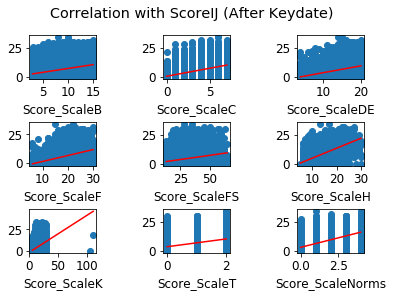

In [250]:
font = {'family' : 'DejaVu Sans',
  'size' : 12}
plt.rc('font', **font)

ax0 = plt.subplot(331)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyB,Y_akey)
mn0=np.min(X_akeyB)
mx0=np.max(X_akeyB)
x0=np.linspace(mn0,mx0,500)
y0=gradient*x0+intercept
ax0.scatter(X_akeyB,Y_akey)
ax0.plot(x0,y0,'-r')
ax0.set_xlabel('Score_ScaleB')

ax1 = plt.subplot(332)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyC,Y_akey)
mn1=np.min(X_akeyC)
mx1=np.max(X_akeyC)
x1=np.linspace(mn1,mx1,500)
y1=gradient*x1+intercept
ax1.scatter(X_akeyC,Y_akey)
ax1.plot(x1,y1,'-r')
ax1.set_xlabel('Score_ScaleC')

ax2 = plt.subplot(333)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyDE,Y_akey)
mn2=np.min(X_akeyDE)
mx2=np.max(X_akeyDE)
x2=np.linspace(mn2,mx2,500)
y2=gradient*x2+intercept
ax2.scatter(X_akeyDE,Y_akey)
ax2.plot(x2,y2,'-r')
ax2.set_xlabel('Score_ScaleDE')

ax3 = plt.subplot(334)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyF,Y_akey)
mn3=np.min(X_akeyF)
mx3=np.max(X_akeyF)
x3=np.linspace(mn3,mx3,500)
y3=gradient*x3+intercept
ax3.scatter(X_akeyF,Y_akey)
ax3.plot(x3,y3,'-r')
ax3.set_xlabel('Score_ScaleF')

ax4 = plt.subplot(335)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyFS,Y_akey)
mn4=np.min(X_akeyFS)
mx4=np.max(X_akeyFS)
x4=np.linspace(mn4,mx4,500)
y4=gradient*x4+intercept
ax4.scatter(X_akeyFS,Y_akey)
ax4.plot(x4,y4,'-r')
ax4.set_xlabel('Score_ScaleFS')

ax5 = plt.subplot(336)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyH,Y_akey)
mn5=np.min(X_akeyH)
mx5=np.max(X_akeyH)
x5=np.linspace(mn5,mx5,500)
y5=gradient*x5+intercept
ax5.scatter(X_akeyH,Y_akey)
ax5.plot(x5,y5,'-r')
ax5.set_xlabel('Score_ScaleH')

ax6 = plt.subplot(337)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyK,Y_akey)
mn6=np.min(X_akeyK)
mx6=np.max(X_akeyK)
x6=np.linspace(mn6,mx6,500)
y6=gradient*x6+intercept
ax6.scatter(X_akeyK,Y_akey)
ax6.plot(x6,y6,'-r')
ax6.set_xlabel('Score_ScaleK')

ax7 = plt.subplot(338)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyT,Y_akey)
mn7=np.min(X_akeyT)
mx7=np.max(X_akeyT)
x7=np.linspace(mn7,mx7,500)
y7=gradient*x7+intercept
ax7.scatter(X_akeyT,Y_akey)
ax7.plot(x7,y7,'-r')
ax7.set_xlabel('Score_ScaleT')

ax8 = plt.subplot(339)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyNorms,Y_akey)
mn8=np.min(X_akeyNorms)
mx8=np.max(X_akeyNorms)
x8=np.linspace(mn8,mx8,500)
y8=gradient*x8+intercept
ax8.scatter(X_akeyNorms,Y_akey)
ax8.plot(x8,y8,'-r')
ax8.set_xlabel('Score_ScaleNorms')

plt.subplots_adjust(wspace = 1, hspace= 1) 
plt.suptitle("Correlation with ScoreIJ (After Keydate)")
plt.show()

#### Note: The above graphs represent the correlation relationship between the significant predictors shown in the after_keydate models and the ScoreIJ (our outcome variable)

In [152]:
# Note the difference in argument order
model_akeyB = sm.OLS(Y_akey, X_akeyB).fit()
predictions_akeyB = model_akeyB.predict(X_akeyB) # make the predictions by the model

# Print out the statistics
model_akeyB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                 2.449e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:04:11   Log-Likelihood:                -59862.
No. Observations:               20317   AIC:                         1.197e+05
Df Residuals:                   20316   BIC:                         1.197e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleB     0.7328      0.005    156.497      0.000       0.724       0.742
==============================================================================
Omnibus:                     4228.736   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9494.925
Skew:                           1.192   Prob(JB):                         0.00
Kurtosis:                       5.352   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Linear Regression with Score C and Score IJ

In [155]:
# Note the difference in argument order
model_akeyC = sm.OLS(Y_akey, X_akeyC).fit()
predictions_akeyC = model_akeyC.predict(X_akeyC) # make the predictions by the model

# Print out the statistics
model_akeyB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                 2.449e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:04:20   Log-Likelihood:                -59862.
No. Observations:               20317   AIC:                         1.197e+05
Df Residuals:                   20316   BIC:                         1.197e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleB     0.7328      0.005    156.497      0.000       0.724       0.742
==============================================================================
Omnibus:                     4228.736   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9494.925
Skew:                           1.192   Prob(JB):                         0.00
Kurtosis:                       5.352   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

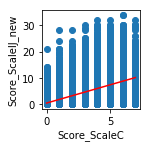

In [158]:
ax1 = plt.subplot(232)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyC,Y_akey)
mn=np.min(X_akeyC)
mx=np.max(X_akeyC)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
ax1.scatter(X_akeyC,Y_akey)
ax1.plot(x1,y1,'-r')
ax1.set_xlabel('Score_ScaleC')
ax1.set_ylabel('Score_ScaleIJ_new')
plt.show()

In [154]:
#build linear regression models

X_akeyC = df_akey['Score_ScaleC']
Y_akey= df_akey["Score_ScaleIJ_new"]

## Scratch Part

In [118]:
# Figuring out how many nan entries there are in the original data
a = X_bkey.Score_ScaleA - X_bkey.Score_ScaleA

for col in cnames:
    a += X_bkey[col]
    
a.isna().sum()

In [25]:
# Data frame with only questionnaire responses

df_question =df.loc[:,"a1_combo":"EG85a"]
df_question['UniqueID'] = df['UniqueID']
cols = df_question.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_question = df_question[cols]
df_question.head()

,UniqueID,a1_combo,a2_combo,a3_combo,a4_combo,a5_combo,a6_combo,b7_combo,b8_combo,b9_combo,...,eg77_most,eg77_no_group,eg77_oldest,eg77_youngest,EG83a,EG83b,EG83c,EG83d,EG83e,EG85a
0,1010,1.0,5.0,3.0,1.0,1.0,1.0,3.0,5.0,3.0,...,,,,,,,,,,NaN
1,1010,4.0,3.0,2.0,1.0,2.0,1.0,3.0,2.0,2.0,...,18,,25,18,9,9,9,9,,NaN
2,1042,2.0,2.0,3.0,1.0,3.0,1.0,4.0,3.0,3.0,...,,,,,,,,,,NaN
3,1043,4.0,3.0,4.0,1.0,4.0,3.0,5.0,5.0,5.0,...,,,,,,,,,,NaN
4,1043,2.0,3.0,3.0,1.0,2.0,2.0,3.0,3.0,3.0,...,18,,26,15,1,0,0,1,,1.0


## Aviva's Code for Data Cleaning

In [ ]:
df['y_DateS1_Interview'] = pd.to_datetime(df['y_DateS1_Interview'], errors='coerce')
df = df.sort_values(by=['y_DateS1_Interview'])

df['y_TotalFactors'] = pd.to_numeric(df['y_TotalFactors'], downcast='integer', errors='coerce')
df.loc[(df['y_TotalFactors'] == 88), 'y_TotalFactors'] = np.nan

df['Age'] = pd.to_numeric(df['Age'], downcast='integer', errors='coerce')
df.loc[(df['Age'] == 99), 'Age'] = np.nan

df['AgeYSET'] = pd.to_numeric(df['AgeYSET'], errors='coerce')
df.loc[(df['AgeYSET'] == 0), 'AgeYSET'] = np.nan

df['YSET_I_R'] = pd.to_numeric(df['YSET_I_R'], errors='coerce')
df['y_YSET_IR_Recoded'] = pd.to_numeric(df['y_YSET_IR_Recoded'], errors='coerce')

df['ETO_ID'] = pd.to_numeric(df['ETO_ID'], errors='coerce')
df['NewRootID'] = df['NewRootID'].replace(' ',np.NaN)
df['OldRootID'] = df['OldRootID'].replace(' ',np.NaN)
df['UniqueID'] = df['ETO_ID']
df = df[key.index]

## Validate/Fill in Risk Factor
# Raw responses
# See README.md for explanation of which questions are included
RF_qs = key.loc['a1_combo':'ij42_6mos_combo'].index.tolist() + key.loc['ij43_ever_combo':'ij56_ever_combo'].index.tolist()
raw_qs = key.loc['a1_combo':'ij56_gang'].index.tolist() + key.loc['ck90':'EG86b'].index.tolist() + key.loc['gm57_6mos_combo':'gm60a'].index.tolist() + key.loc['h36_1_new':'P5_new'].index.tolist() + key.loc['xr_L72_awarenessXX':'xr_m71_codeXX'].index.tolist() 
for q in raw_qs:
    df[q] = pd.to_numeric(df[q], errors='coerce')
    
scale_scores = key.loc['Score_ScaleA':'Score_ScaleNorms'].index.tolist()
for score in scale_scores:
    df[score] = pd.to_numeric(df[score], errors='coerce')
    
scale_concerns = key.loc['ScoreA':'ScoreT'].index.tolist()
for concern in scale_concerns:
    df[concern] = pd.to_numeric(df[concern], errors='coerce')
    df.loc[(df[concern] == 7), concern] = np.nan
scale_concerns.append('ScoreK')
df['ScoreK'] = pd.to_numeric(df['ScoreK'], errors='coerce')
df.loc[(df['ScoreK'] == 4), 'ScoreK'] = np.nan
scale_concerns.append('ScoreGroupFriends')
df['ScoreGroupFriends'] = pd.to_numeric(df['ScoreGroupFriends'], errors='coerce')
df.loc[(df['ScoreGroupFriends'] == 4), 'ScoreGroupFriends'] = np.nan

scale_flags = key.loc['y_ARISK_NY':'y_TRISK_NY'].index.tolist()
for flag in scale_flags:
    df[flag] = pd.to_numeric(df[flag], errors='coerce')
    
def scale_score_calculate(df):
    scale_a = np.sum(df.loc[:,'a1_combo':'a6_combo'], axis=1).rename('scale_a')
    scale_b = np.sum(df.loc[:,'b7_combo':'b9_combo'], axis=1).rename('scale_b')
    scale_c = np.sum(df.loc[:,'c10_combo':'c16_combo'], axis=1).rename('scale_c')
    scale_de = np.sum(df.loc[:,'de17_combo':'de20_combo'], axis=1).rename('scale_de')
    scale_f = np.sum(df.loc[:,'f21_combo':'f26_combo'], axis=1).rename('scale_f')
    scale_g = np.sum(df.loc[:,'g27_combo':'g31_combo'], axis=1).rename('scale_g')
    scale_h = np.sum(df.loc[:,'h32_combo':'h37_combo'], axis=1).rename('scale_h')
    scale_ij = np.sum(df.loc[:,RF_qs[39:]], axis=1).rename('scale_ij')
    scale_t = np.add((df.loc[:,'t38_combo'] > 1).astype(int),(df.loc[:,'t39_combo'] > 1).astype(int)).rename('scale_t')
    
    # Not used for risk factor
    scale_fs = np.sum(df.loc[:,'FS91':'FS104'], axis=1).rename('scale_fs')
    scale_k = np.sum(df.loc[:,'k61':'k66'], axis=1).rename('scale_k')
    scale_m = np.sum(df.loc[:,'xr_m67_codeXX':'xr_m71_codeXX'], axis=1).rename('scale_m')
    scale_l = np.sum(df.loc[:,'xr_L72_awarenessXX':'xr_L75_awarenessXX'], axis=1).rename('scale_l')
    scale_p = np.sum(df.loc[:, 'P1_new':'P5_new'], axis=1).rename('scale_p')
    scale_norms = np.sum(df.loc[:, 'EG80':'EG85a'], axis=1).rename('scale_norms')
    # scale_conv uses xr_n90_groupXX, not computing at this time. (but if I were, I'd do it here.)
    
    df2 = pd.concat([scale_a, scale_b, scale_c, scale_de, scale_f, scale_g, scale_h, scale_ij, scale_t, scale_fs, scale_k, scale_m, scale_l, scale_p, scale_norms], axis=1)
    return df2

scale_scores_constructed = ['scale_a', 'scale_b', 'scale_c', 'scale_de', 'scale_f', 'scale_g', 'scale_h', 'scale_ij', 'scale_t', 'scale_fs', 'scale_k', 'scale_p', 'scale_norms'] #skipping M and L because it doesn't exist in the dataset

calculated_scores = scale_score_calculate(df)
different = (df[scale_scores].values != calculated_scores[scale_scores_constructed].values)

for i in range(len(scale_scores_constructed)):
    print(scale_scores_constructed[i], np.sum(different, axis=0)[i])


## Check if all values of a key are covered
#target = 'ReferralSource'
#all_data = pd.to_numeric(df[target], errors='coerce')
#info = key[key['key']==target]
#values = literal_eval(info['values'].max())
#value_keys = [i[0] for i in values]
#
#present = all_data[np.isin(all_data, value_keys)]
#missing = all_data[~np.isin(all_data, value_keys)]
###test = df['y_YSET_InterviewDateRecorded']
##
##old = pd.read_csv('../data/YSET_Database_January_2014_Decebmer_2017_Clean_Data.csv')

## Compare YSET_I_R with y_YSET_IR_Recoded
# Number crunching
#intake_IR = sum(df['YSET_I_R'] < 10)
#retake_IR = sum(df['YSET_I_R'] >= 10)
#intake_recoded = sum(df['y_YSET_IR_Recoded'] == 1)
#retake_recoded = sum(df['y_YSET_IR_Recoded'] == 2)
#matching_IR = sum((df['YSET_I_R'] < 10) & (df['y_YSET_IR_Recoded'] == 1)) + sum((df['YSET_I_R'] >= 10) & (df['y_YSET_IR_Recoded'] == 2))
#can_fill = sum((df['YSET_I_R'] < 10) & (df['y_YSET_IR_Recoded'].isnull())) + sum((df['YSET_I_R'] >= 10) & (df['y_YSET_IR_Recoded'].isnull())) + sum((df['YSET_I_R'].isnull()) & (df['y_YSET_IR_Recoded'] == 1)) + sum((df['YSET_I_R'].isnull()) & (df['y_YSET_IR_Recoded'] == 2))

# Repopulate as many entries as possible (4)
df.loc[(df['YSET_I_R'] < 10) & (df['y_YSET_IR_Recoded'].isnull()), 'y_YSET_IR_Recoded'] = 1

# Drop all conflicting entries (56)
df = df.drop(df[(df['YSET_I_R'] < 10) & (df['y_YSET_IR_Recoded'] == 2)].index)
df = df.drop(df[(df['YSET_I_R'] >= 10) & (df['y_YSET_IR_Recoded'] == 1)].index)
df = df.dropna(subset=['YSET_I_R', 'y_YSET_IR_Recoded'])

## Construct UniqueID
#  1. From ETO_ID (high confidence of accuracy)
df.loc[(df['UniqueID'] == 0), 'UniqueID'] = np.nan
df.loc[(df['UniqueID'] == 88888), 'UniqueID'] = np.nan
df.loc[(df['UniqueID'] == 99999), 'UniqueID'] = np.nan

#current_count = sum(df['UniqueID'].notnull())  # 28,436

#  2. Recover missing ETO_ID using matching NewRootID entries, then OldRootID entries
def fill_nan(df, key='NewRootID', target='UniqueID'):
    df.loc[df.dropna(subset=[key]).index, target] = df.dropna(subset=[key]).groupby([key])[target].fillna(method='backfill')
    df.loc[df.dropna(subset=[key]).index, target] = df.dropna(subset=[key]).groupby([key])[target].fillna(method='ffill')
    return df

df = fill_nan(df, key='NewRootID', target='UniqueID')
#current_count = sum(df['UniqueID'].notnull()) # 28,478
df = fill_nan(df, key='OldRootID', target='UniqueID')
#current_count = sum(df['UniqueID'].notnull()) # 28,690

## If the same identifier has Y1s associated with it, drop all but the first
def drop_duplicate_Y1(df, key='ETO_ID'):
    test = (df[df['YSET_I_R'] == 1][key].duplicated(keep='first')) & (df[df['YSET_I_R'] == 1][key].notnull()) & ~(df['YSET_I_R'] != 1)
#    print(sum(test))
    df = df[~test]
    return df

df = drop_duplicate_Y1(df, key='UniqueID')    # drop 95
df = drop_duplicate_Y1(df, key='NewRootID')   # drop 8
df = drop_duplicate_Y1(df, key='OldRootID')   # drop 81

# Assign a four digit number to Y1 entries (guaranteed to correspond to one person due to previous steps)
number_assigned = df.loc[(df['YSET_I_R']==1) & (df['UniqueID'].isnull()),'UniqueID'].shape[0]
df.loc[(df['YSET_I_R']==1) & (df['UniqueID'].isnull()),'UniqueID'] = range(1000, number_assigned + 1000)

# Fill in corresponding Yn and Rn responses for the new UniqueIDs using RootID values
df = fill_nan(df, key='NewRootID', target='UniqueID')
#current_count = sum(df['UniqueID'].notnull())  # 34,298
df = fill_nan(df, key='OldRootID', target='UniqueID')
current_count = sum(df['UniqueID'].notnull()) # 36,017

df = df.dropna(subset=['UniqueID'])
df = df.dropna(subset=RF_qs) # If the questions are not filled in, we must drop

# If the risk factor is not recorded in 'y_TotalFactors', add it.
def calculate_RF(df):
    age_ind=df.loc[:,'Age']>12
    scale_a = (np.sum(df.loc[:,'a1_combo':'a6_combo'], axis=1) > 15).astype(int)
    scale_b = (np.sum(df.loc[:,'b7_combo':'b9_combo'], axis=1) > 6).astype(int)
    scale_c = (np.sum(df.loc[:,'c10_combo':'c16_combo'], axis=1) > 3).astype(int)
    scale_de = (np.sum(df.loc[:,'de17_combo':'de20_combo'], axis=1) > 13).astype(int)
    scale_f = (np.sum(df.loc[:,'f21_combo':'f26_combo'], axis=1) > 18).astype(int)
    scale_g = (np.sum(df.loc[:,'g27_combo':'g31_combo'], axis=1) > 12).astype(int)
    scale_h = (np.sum(df.loc[:,'h32_combo':'h37_combo'], axis=1) > 11).astype(int) # age difference
    scale_h[age_ind] = (np.sum(df.loc[age_ind,'h32_combo':'h37_combo'], axis=1) > 13).astype(int)
    t38 = df.loc[:,'t38_combo'] > 1
    t39 = df.loc[:,'t39_combo'] > 1
    scale_t = (t38 | t39).astype(int)
    scale_ij = np.sum(df.loc[:,'ij40_6mos_combo':'ij56_ever_combo'], axis=1) > 3 # age difference
    scale_ij[age_ind] = np.sum(df.loc[age_ind,'ij40_6mos_combo':'ij56_ever_combo'], axis=1) > 5
            
    return (scale_a + scale_b + scale_c + scale_de + scale_f + scale_g + scale_h + scale_t + scale_ij)

test = df.dropna(subset=['y_TotalFactors'])
test2 = test[test['y_TotalFactors'] != calculate_RF(test)]['y_TotalFactors']
print(test2.value_counts())

df = df.sort_values(by=['UniqueID', 'y_DateS1_Interview'])
df.to_csv('../data/YSET_Dec2008_Dec2019_cleaned20190531.csv', columns=key.index)